In [1]:
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rlcard
from rlcard.envs.registration import register, make

from briscolaAI.briscola import BriscolaEnv
from briscolaAI.game import BriscolaGame
from briscolaAI.agent import BriscolaRuleAgent
from briscolaAI.human import HumanAgent
from briscolaAI.dqn_agent import DQNAgent

In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
def rl_based_action(player, env, state):
    action_idx = player.action_if_win(env.game)
    would_be_winning = False
    if action_idx != None:
        action = player.hand.index(action_idx)
        would_be_winning = True
    Qvalues = softmax(player.predict(state))
    if np.max(Qvalues) >= 0.666 or len(env.game.dealer.deck) >= 10:
        action = np.argmax(Qvalues)
    else:
        action = random.choices(range(len(Qvalues)), Qvalues, k=1)[0]        
    return action, would_be_winning

def random_action(player, env):
    return player.hand.index(player.random_card())
    
def rule_based_action(player, env, epsilon = 0.0):
    return player.hand.index(player.rule_card(env.game, epsilon))

def human_action(player, env):
    return player.throw_card()

def run_eval_games(env, action_func, n, print_game = False):
    game_results = {"win": 0, "odds": 0, "loss": 0}
    points_results = []
    rule_not_learned = 0
    rule_all = 0
    for _ in range(n):
        if print_game: print("\nNew Game\n")
        state, player_id = env.reset()
        if print_game: print(f"Briscola is {env.game.judger.briscola}\n")
        agent_id = env.game.agent_id
        would_win_times = 0
        while True:
            player = env.game.players[player_id]
            if player_id == agent_id:
                action, would_win = rl_based_action(player, env, state)
                if print_game: print(f"AI plays: {player.hand[action]}\n")
                would_win_times += would_win
            else:
                action = action_func(player, env)
                if print_game: print(f"Human plays: {player.hand[action]}\n")
            next_state, player_id = env.step(action)
            if player_id is None: break
            state = next_state 
        winner = env.game.winner
        points = env.game.judger.compute_points(env.game.players[env.game.agent_id].pile)
        if print_game:
            print(f"Your pile is {[str(x) for x in env.game.players[(agent_id - 1) % 2].pile]}\n")
            print(f"\nWinner is {'AI' if points > 60 else ('None' if points == 60 else 'Human')}")
        rule_not_learned += points <= 60 and would_win_times >= 1
        rule_all += would_win_times >= 1
        points_results.append(points)
        
        result_k = "win" if winner == (agent_id,) else ("odds" if len(winner) == 2 else "loss")
        game_results[result_k] += 1
    return game_results, points_results, rule_not_learned, rule_all

def eval_agent(env):
    random_results, random_points_results, not_rule_prob_random, all_prob_random = run_eval_games(env, random_action, 1000)
    rule_based_results, rule_points_results, not_rule_prob_rule, all_prob_rule = run_eval_games(env, rule_based_action, 1000)
    #print_results(random_results, "random")
    #print_results(rule_based_results, "rule")
    return random_points_results, rule_points_results, (not_rule_prob_random + not_rule_prob_rule) / (all_prob_random + all_prob_rule)

def print_results(results, player_type):
	str_results = " ".join(f"{k}: {results[k]}" for k in results)
	print(f"agent vs. {player_type} -> {str_results}")

In [3]:
try:
	register(
    	env_id='briscola',
    	entry_point='briscolaAI.briscola:BriscolaEnv',
	)
except ValueError:
	pass

results_points_random = []
results_points_rule = []
results_not_rule_prob = []
for x in range(0, 100001, 1000):
    model = torch.load(f"./models/checkpoint_dqn_episode_{x}.pt") 
    agent = DQNAgent.from_checkpoint(model)
    config = {
    	"players": [
    		agent, 
    		BriscolaRuleAgent(1, np.random)
    	]
    }

    env = make('briscola', config = config)
    vs_random_points, vs_rule_points, not_rule_prob = eval_agent(env)
    avg_points_random = sum(vs_random_points) / len(vs_random_points)
    avg_points_rule = sum(vs_rule_points) / len(vs_rule_points)
    won_random = sum(x > 60 for x in vs_random_points) / 1000
    won_rule = sum(x > 60 for x in vs_rule_points) / 1000
    print(avg_points_random, won_random)
    print(avg_points_rule, won_rule)
    
    print(not_rule_prob)
    results_points_random.append([avg_points_random, won_random])
    results_points_rule.append([avg_points_rule, won_rule])
    results_not_rule_prob.append(not_rule_prob)


INFO - Restoring model from checkpoint...
60.217 0.492
42.352 0.173
0.06538461538461539

INFO - Restoring model from checkpoint...
60.221 0.489
40.648 0.158
0.08487084870848709

INFO - Restoring model from checkpoint...
60.632 0.495
42.489 0.164
0.07423580786026202

INFO - Restoring model from checkpoint...
61.076 0.519
44.323 0.203
0.04017857142857143

INFO - Restoring model from checkpoint...
63.009 0.546
44.341 0.197
0.08695652173913043

INFO - Restoring model from checkpoint...
63.566 0.548
44.757 0.19
0.05904059040590406

INFO - Restoring model from checkpoint...
62.039 0.522
44.492 0.198
0.08860759493670886

INFO - Restoring model from checkpoint...
65.128 0.59
46.126 0.219
0.06756756756756757

INFO - Restoring model from checkpoint...
66.496 0.611
49.211 0.27
0.053156146179401995

INFO - Restoring model from checkpoint...
66.651 0.621
47.718 0.243
0.026706231454005934

INFO - Restoring model from checkpoint...
68.591 0.648
52.209 0.314
0.03355704697986577

INFO - Restoring mode

In [8]:
# Interesting results:

# - 89% winrate vs. agent playing randomly
# - 63% winrate vs. agent playing with rules
# - The agent actually learnt to throw the card that
#   let him win when it has the occasion of reaching 
#   the 61 points threshold
# - 

# Possible improvements:

# - Improve the reward function by considering the 61 points threshold
# - Use some strict rules to play the endgame perfectly
# - Test different architectures
# - Try self-play after first stage of training vs. random and rule agents
# - Do some hyperparameter-tuning


In [ ]:
results_points_random = [[x/120, y] for x, y in results_points_random]
results_points_rule = [[x/120, y] for x, y in results_points_rule]

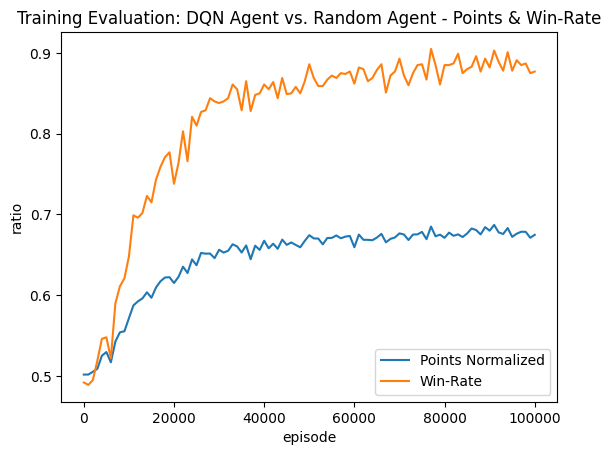

In [12]:
results_points_random_df = pd.DataFrame(results_points_random)
results_points_random_df.columns = ["Points Normalized", "Win-Rate"]
results_points_random_df.index *= 1000
results_points_random_df.plot(title="Training Evaluation: DQN Agent vs. Random Agent - Points & Win-Rate", xlabel="episode", ylabel="ratio")
plt.savefig('./results/Agent_vs_Random_Points.png', dpi=300)
plt.show()

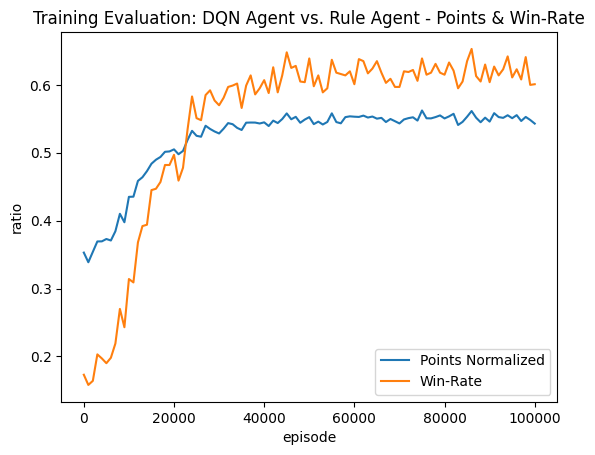

In [13]:
results_points_rule_df = pd.DataFrame(results_points_rule)
results_points_rule_df.columns = ["Points Normalized", "Win-Rate"]
results_points_rule_df.index *= 1000
results_points_rule_df.plot(title="Training Evaluation: DQN Agent vs. Rule Agent - Points & Win-Rate", xlabel="episode", ylabel="ratio")
plt.savefig('./results/Agent_vs_Random_Points.png', dpi=300)
plt.show()

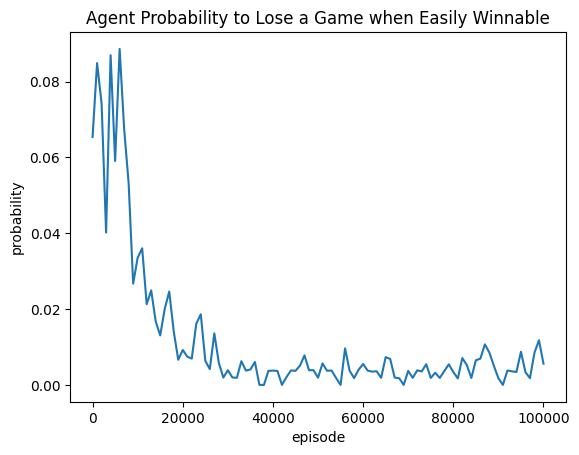

In [6]:
plt.plot(range(0, 100001, 1000), results_not_rule_prob)
plt.title("Agent Probability to Lose a Game when Easily Winnable")
plt.xlabel("episode")
plt.ylabel("probability")
plt.savefig('./results/Agent_Simple_Rule_Not_Learned.png', dpi=300)
plt.show()

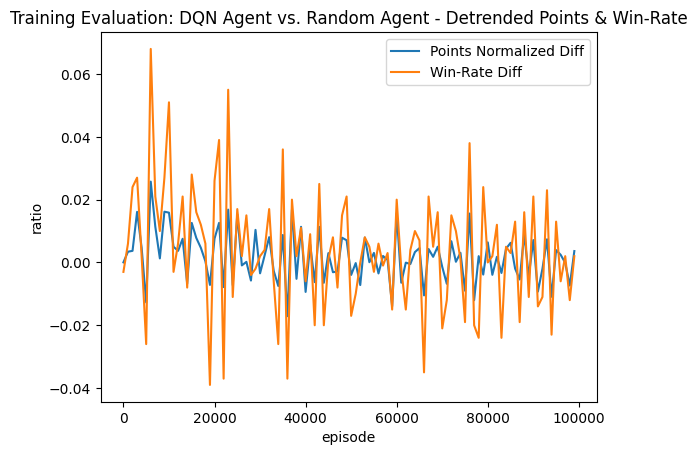

In [15]:
results_points_random_df = pd.DataFrame([[y[0]-x[0], y[1]-x[1]] for (x, y) in zip(results_points_random, results_points_random[1:])])
results_points_random_df.columns = ["Points Normalized Diff", "Win-Rate Diff"]
results_points_random_df.index *= 1000
results_points_random_df.plot(title="Training Evaluation: DQN Agent vs. Random Agent - Detrended Points & Win-Rate", xlabel="episode", ylabel="ratio")
plt.savefig('./results/Agent_vs_Random_Points.png', dpi=300)
plt.show()

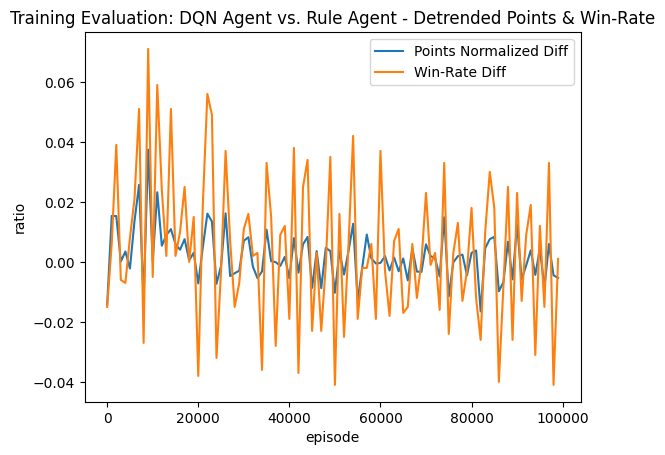

In [16]:
results_points_rule_df = pd.DataFrame([[y[0]-x[0], y[1]-x[1]] for (x, y) in zip(results_points_rule, results_points_rule[1:])])
results_points_rule_df.columns = ["Points Normalized Diff", "Win-Rate Diff"]
results_points_rule_df.index *= 1000
results_points_rule_df.plot(title="Training Evaluation: DQN Agent vs. Rule Agent - Detrended Points & Win-Rate", xlabel="episode", ylabel="ratio")
plt.savefig('./results/Agent_vs_Random_Points.png', dpi=300)
plt.show()